## Using Lowess to smooth noisy data

In [28]:
import itertools
import numpy as np
import pandas as pd

import random

from statsmodels.nonparametric.smoothers_lowess import lowess

In [4]:
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import seaborn as sns

In [18]:
sns.set_theme()
figsize(12, 6)

[This article](https://medium.economist.com/mistakes-weve-drawn-a-few-8cdd8a42d368) suggests that a smooth curve is a better way to show noisy polling data over time.

Here's their before and after:

![](https://cdn-images-1.medium.com/max/800/1*9GzHVtm4y_LeVmFCjqV3Ww.png)

And here's their data:

In [134]:
df = pd.read_csv('../data/economist_brexit.csv', header=3, parse_dates=[0])
df.rename(columns={
    '% responding right': 'right',
    '% responding wrong': 'wrong'
}, inplace=True)
# df.index = df['Date']
df.head()

,Date,right,wrong
0,2016-02-08,46,42
1,2016-09-08,45,44
2,2016-08-17,46,43
3,2016-08-23,45,43
4,2016-08-31,47,44


In [135]:
df.tail()

,Date,right,wrong
80,2018-08-13,43,47
81,2018-08-14,43,45
82,2018-08-21,41,47
83,2018-08-29,42,47
84,2018-04-09,42,48


The following function uses StatsModels to put a smooth curve through a time series (and stuff the results back into a Pandas Series)

In [138]:
df_long = df.melt(
    id_vars = 'Date',
    value_vars = df.columns[1:],
    value_name = 'Percentage',
    var_name = 'Response'
)
df_long

,Date,Response,Percentage
0,2016-02-08,right,46
1,2016-09-08,right,45
2,2016-08-17,right,46
3,2016-08-23,right,45
4,2016-08-31,right,47
...,...,...,...
165,2018-08-13,wrong,47
166,2018-08-14,wrong,45
167,2018-08-21,wrong,47
168,2018-08-29,wrong,47


As you can see, its a very noisy dataset

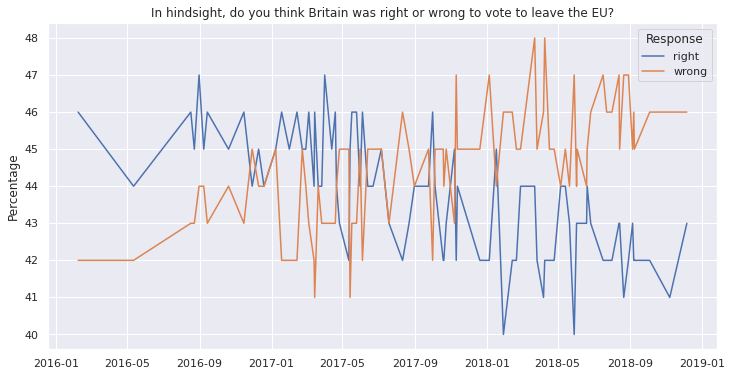

In [139]:
title = 'In hindsight, do you think Britain was right or wrong to vote to leave the EU?'
p = sns.lineplot(
    data = df_long,
    x = 'Date',
    y = 'Percentage',
    hue = 'Response'
);
p.set(
    xlabel = None,
    title = title
);

A scatter plot doesn't make things any clearer

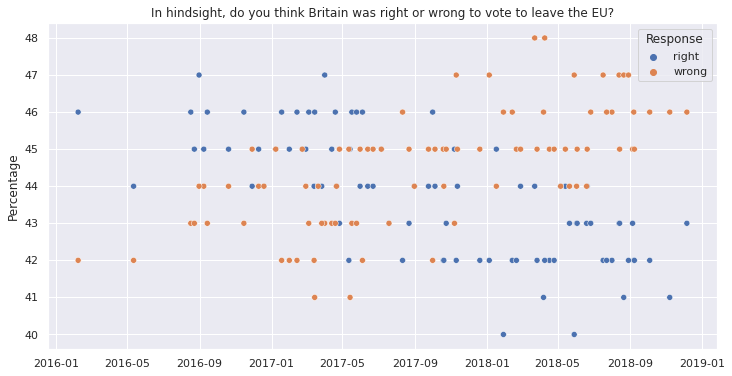

In [140]:
p = sns.scatterplot(
    data = df_long,
    x = 'Date',
    y = 'Percentage',
    hue = 'Response'
)
p.set(
    xlabel = None,
    title = title
);

To fit a [lowess](https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.smoothers_lowess.lowess.html) curve we needs the x values of the observed points (the date) and the y values (the % response)

In [141]:
right_smooth = lowess(df['right'], df.Date, return_sorted=False)
wrong_smooth = lowess(df['wrong'], df.Date, return_sorted=False)

In [142]:
df_long['lowess'] = list(itertools.chain(right_smooth, wrong_smooth))

In [143]:
# or
df_long['lowess'] = np.hstack((right_smooth, wrong_smooth,))

In [144]:
df_long.head()

,Date,Response,Percentage,lowess
0,2016-02-08,right,46,46.089707
1,2016-09-08,right,45,45.464143
2,2016-08-17,right,46,45.533300
3,2016-08-23,right,45,45.514484
4,2016-08-31,right,47,45.489340


In [145]:
df.Date.apply(lambda row: row.strftime('%b %Y'))

0     Feb 2016
1     Sep 2016
2     Aug 2016
3     Aug 2016
4     Aug 2016
        ...   
80    Aug 2018
81    Aug 2018
82    Aug 2018
83    Aug 2018
84    Apr 2018
Name: Date, Length: 85, dtype: object

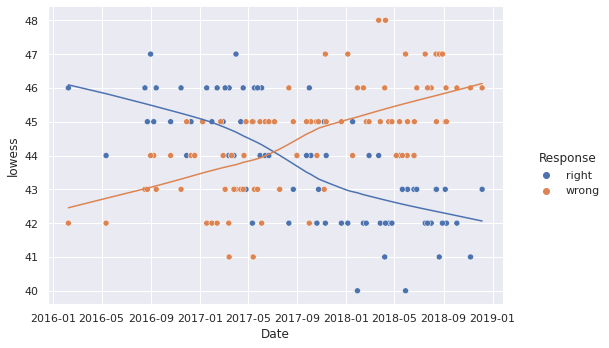

In [149]:
# relplot returns a FacetGrid instance
p = sns.relplot(
    kind='scatter',
    x='Date',
    y='Percentage',
    hue = 'Response',
    data=df_long,
    height=5,
    aspect=1.5
)
p.set_axis_labels('', 'Percentage');
p.map_dataframe(sns.lineplot, 'Date', 'lowess', hue='Response');

Not great. Its better to use subplots

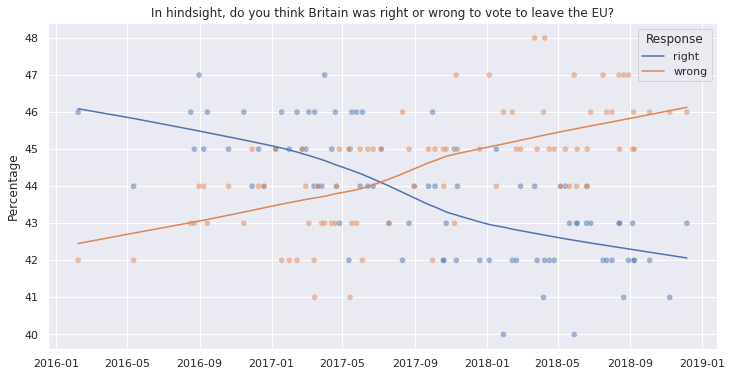

In [150]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=df_long,
    x='Date',
    y='Percentage',
    hue='Response',
    legend=False,
    ax=ax,
    alpha=0.5
)
sns.lineplot(
    data=df_long,
    x='Date',
    y='lowess',
    hue='Response',
    ax=ax
);
ax.set_title(title);
ax.set_xlabel('');